In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets
import numpy as np
from keras.utils import to_categorical
from keras import backend as K
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_context('notebook')
sns.set_style('whitegrid')

In [2]:
img_rows, img_cols = 32, 32  
batch_size = 64
num_classes = 2
epochs = 50

(X_train, y_train), (X_test, y_test) = cifar10.load_data()  

train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     
y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)
X_train = X_train[train_picks]
X_test = X_test[test_picks]

In [3]:
print(len(X_train))
print(len(X_test))

10000
2000


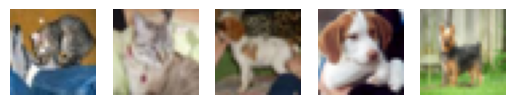

In [4]:

for i, img in enumerate(X_test):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    if i == 4:
        break
plt.show()

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [7]:
def cnn_model() : 
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    return(model)

In [8]:
model1 = cnn_model()
learning_rate = 0.1
sgd = SGD(learning_rate==learning_rate, momentum=0.0, decay=0.0, nesterov=False) # set to default except lr
model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
history1 = model1.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 4)         112       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         296       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 16)                25104     
                                                        

In [9]:
def plot_acc(train, val):
    plt.tight_layout()
    plt.plot(train, label='training')
    plt.plot(val, label='validation')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [10]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

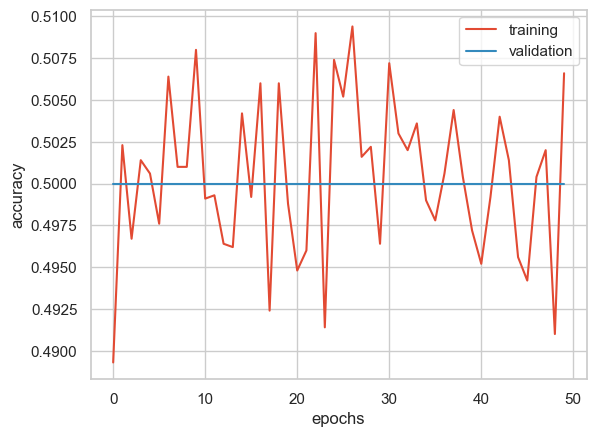

In [11]:
plot_acc(history1.history['accuracy'], history1.history['val_accuracy'])

In [12]:
model2 = cnn_model()
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.5
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, 
                     epochs=epochs, 
                     batch_size=batch_size,
                     verbose=1, 
                     validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 4)         112       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 8)         0         
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                25104     
                                                      

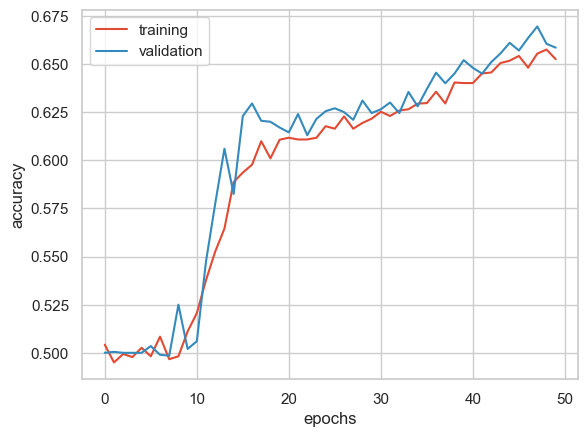

In [13]:
plot_acc(train=history2.history['accuracy'], val=history2.history['val_accuracy'])

In [14]:
model3 = cnn_model()
momentum = 0.5

sgd = SGD(learning_rate=0.0, momentum=momentum, decay=0.0, nesterov=False) 

model3.compile(loss=keras.losses.categorical_crossentropy,optimizer=sgd, metrics=['accuracy'])
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((epoch)/epochs_drop))
    return lrate

loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]
history3 = model3.fit(X_train, y_train, 
                     validation_data=(X_test, y_test), 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     callbacks=callbacks_list, 
                     verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 4)         112       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 8)         296       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 8)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1568)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                25104     
                                                      

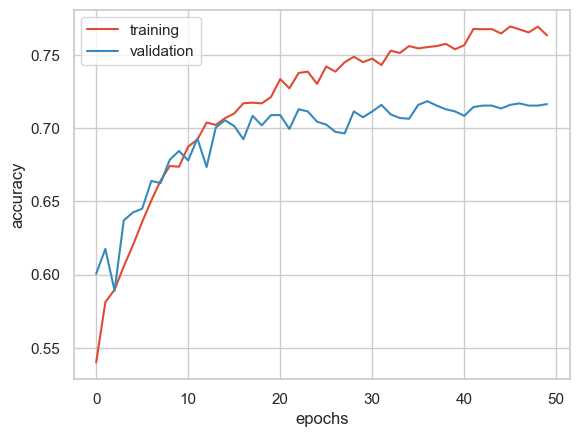

In [15]:
plot_acc(train=history3.history['accuracy'], val=history3.history['val_accuracy'])

In [16]:
model4 = cnn_model()
momentum = 0.8
sgd = SGD(learning_rate=0.0, momentum=momentum, decay=0.0, nesterov=False)
model4.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)
callbacks_list_ = [loss_history_, lrate_]

history4 = model4.fit(X_train, y_train, 
     validation_data=(X_test, y_test), 
     epochs=epochs, 
     batch_size=batch_size, 
     callbacks=callbacks_list_, 
     verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 4)         112       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 8)         296       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 8)         0         
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 dense_6 (Dense)             (None, 16)                25104     
                                                      

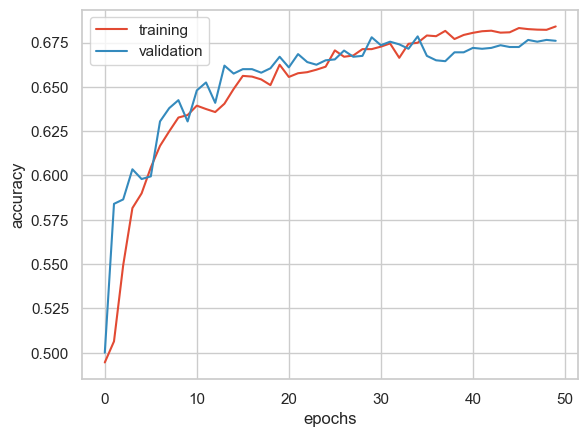

In [17]:
plot_acc(train=history4.history['accuracy'], val=history4.history['val_accuracy'])